In [136]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import  MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns


## Preparación inicial de los datos

In [137]:
df = pd.read_csv('../data/processed/2.1-student_habits_performance_estandarizado.csv')
df = df.drop(['student_id'], axis=1)
df

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,0.857143,0,0.000000,0.214286,0.239130,0,0.629630,0.727273,1.0,6,2.0,1.0,7,1,0.406504
1,0.428571,0,0.920000,0.500000,0.500000,0,0.933333,0.212121,2.0,6,0.0,1.0,7,0,1.000000
2,0.571429,1,0.186667,0.553571,0.282609,0,0.871605,0.727273,0.0,1,0.0,0.0,0,0,0.109756
3,0.857143,0,0.133333,0.696429,0.217391,0,0.283951,0.909091,0.0,4,2.0,2.0,0,1,0.008130
4,0.285714,0,0.666667,0.785714,0.108696,0,0.775309,0.257576,1.0,3,2.0,2.0,0,0,0.544715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,0.571429,0,0.346667,0.089286,0.347826,0,0.432099,0.651515,1.0,2,0.0,2.0,5,1,0.676152
936,0.000000,0,0.386667,0.178571,0.521739,1,0.654321,0.545455,0.0,1,0.0,1.0,5,1,0.537940
937,0.428571,1,0.400000,0.464286,0.282609,0,0.059259,0.500000,2.0,5,1.0,2.0,8,1,0.517615
938,1.000000,1,0.720000,0.732143,0.239130,1,1.000000,0.666667,1.0,0,1.0,1.0,0,0,0.589431


In [138]:
# separo en X & y
X = df.drop(['exam_score'], axis=1)
y = df['exam_score']

In [139]:
X.head(3)

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
0,0.857143,0,0.000000,0.214286,0.239130,0,0.629630,0.727273,1.0,6,2.0,1.0,7,1
1,0.428571,0,0.920000,0.500000,0.500000,0,0.933333,0.212121,2.0,6,0.0,1.0,7,0
2,0.571429,1,0.186667,0.553571,0.282609,0,0.871605,0.727273,0.0,1,0.0,0.0,0,0


In [140]:
y.head(3)

0    0.406504
1    1.000000
2    0.109756
Name: exam_score, dtype: float64

### Prueba de K-fold cross validation con regresión lineal

In [141]:
lr_regressor = LinearRegression()

In [142]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [143]:
scores = cross_val_score(lr_regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_r2 = cross_val_score(lr_regressor, X, y, cv=kf, scoring='r2')

In [144]:
# Convertimos a RMSE
rmse_scores = np.sqrt(-scores)

print("RMSE por fold:", rmse_scores)
print("RMSE promedio:", rmse_scores.mean())

print("R2 por fold:", scores_r2)

RMSE por fold: [0.06765806 0.08115931 0.07444814 0.06015917 0.07602253 0.07562367
 0.06714554 0.07398151 0.07388667 0.0657427 ]
RMSE promedio: 0.07158273176715027
R2 por fold: [0.91446494 0.88644181 0.90100885 0.91086883 0.8993839  0.88163371
 0.9071379  0.90514754 0.87880115 0.91781783]


#### Visualizar los folds de cross validation

In [145]:
def plot_kfold_cv(X, n_splits=10):
    plt.figure(figsize=(12, 6))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    n_samples = len(X)
    indices = np.arange(n_samples)  # solo para graficar el índice

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Graficar puntos azules para entrenamiento
        plt.scatter(train_idx, [i + 1] * len(train_idx), 
                    c='blue', s=20, label='Train' if i == 0 else "")
        
        # Rojos para validación
        plt.scatter(val_idx, [i + 1] * len(val_idx), 
                    c='red', s=20, label='Validation' if i == 0 else "")

    plt.yticks(range(1, n_splits + 1))
    plt.xlabel('Índice de muestra')
    plt.ylabel('Fold')
    plt.title(f'{n_splits}-Fold Cross Validation Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

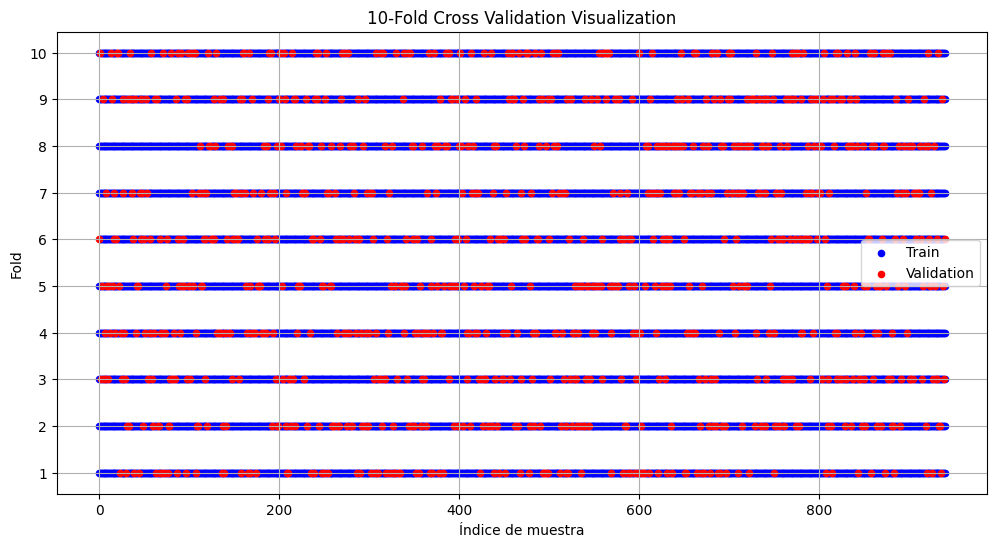

In [146]:
plot_kfold_cv(X, n_splits=10)

## Creación y prueba de modelos de regresión (Uso de Optuna para hiperparametros)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Funciones para graficas usadas

In [148]:
def plot_errores(titulo, errores):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(errores, bins=30, color='purple',  alpha=0.7)
    ax.set_title(f'Distribución de errores ({titulo})')
    ax.set_xlabel('Error (Residual)')
    ax.set_ylabel('Frecuencia')
    ax.grid(True)
    
    

def plot_prediccion_vs_real(titulo, y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f'Predicción vs Real ({titulo})')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción del Modelo')
    plt.grid(True)
    plt.show()
    
    
def plot_importance(titulo, importances):
    feature_names = X_train.columns

    indices = np.argsort(importances)[::-1]  # Orden descendente
    plt.figure(figsize=(15, 6))
    plt.title(f"Importancia de variables - {titulo}")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.show()
    

### Linear Regressor

In [149]:
# se definen los hiperparámetros a optimizar en esta función
def objective_lr(trial):
    
    # hiperparametros a optimizar (ej: entre 50 y 200)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    positive = trial.suggest_categorical("positive", [True, False])

    # crear el modelo
    model = LinearRegression(
        fit_intercept=fit_intercept,
        positive=positive
    )

    # defino el cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    mse_mean = -scores_mse.mean()
    return mse_mean

In [150]:
# optimizacion
study_lr = optuna.create_study(direction='minimize')
study_lr.optimize(objective_lr, n_trials=50)

[I 2025-06-16 09:37:02,702] A new study created in memory with name: no-name-5af6a4c7-f5a1-42ca-a924-6b926581a2bb
[I 2025-06-16 09:37:02,738] Trial 0 finished with value: 0.005142393077017116 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 0 with value: 0.005142393077017116.
[I 2025-06-16 09:37:02,792] Trial 1 finished with value: 0.009380187117589738 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 0.005142393077017116.
[I 2025-06-16 09:37:02,832] Trial 2 finished with value: 0.005103891187733784 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 2 with value: 0.005103891187733784.
[I 2025-06-16 09:37:02,862] Trial 3 finished with value: 0.005142393077017116 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 2 with value: 0.005103891187733784.
[I 2025-06-16 09:37:02,921] Trial 4 finished with value: 0.008169469606890882 and parameters: {'fit_intercept': True, 'positive': Tr

In [151]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para Regresión Lineal:")
print(study_lr.best_params)
print("Mejor MSE:", study_lr.best_value)


Mejores parámetros encontrados para Regresión Lineal:
{'fit_intercept': True, 'positive': False}
Mejor MSE: 0.005103891187733784


In [152]:
# entreno el modelo con los mejores parámetros
best_model_lr_reg = LinearRegression(**study_lr.best_params)
best_model_lr_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [153]:
# evaluación del modelo
y_pred_lr = best_model_lr_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)

r2_lr = r2_score(y_test, y_pred_lr)

print("\nEvaluación del Modelo de Regresión:")
print(f"Regresion Lineal Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"Regresion Lineal R² Score: {r2_lr:.4f}")



Evaluación del Modelo de Regresión:
Regresion Lineal Mean Squared Error (MSE): 0.0056
Regresion Lineal R² Score: 0.9012


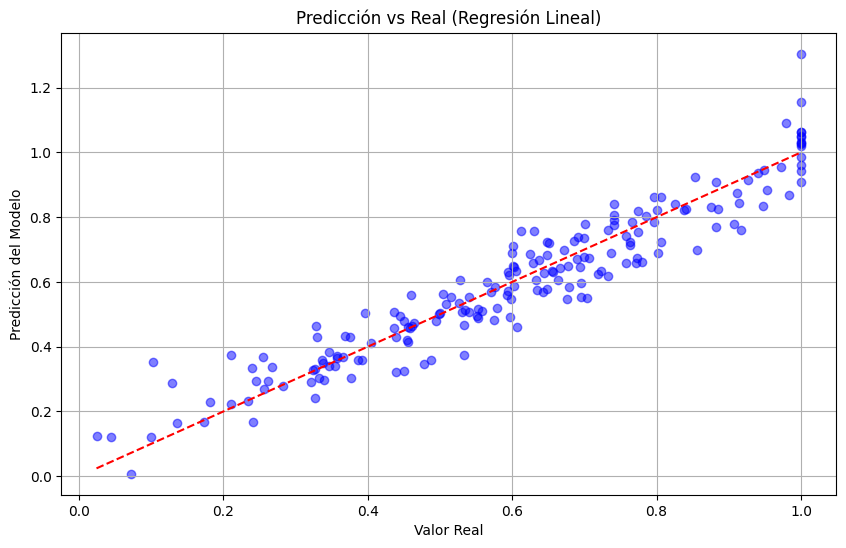

In [154]:
# grafico
plot_prediccion_vs_real("Regresión Lineal", y_test, y_pred_lr)

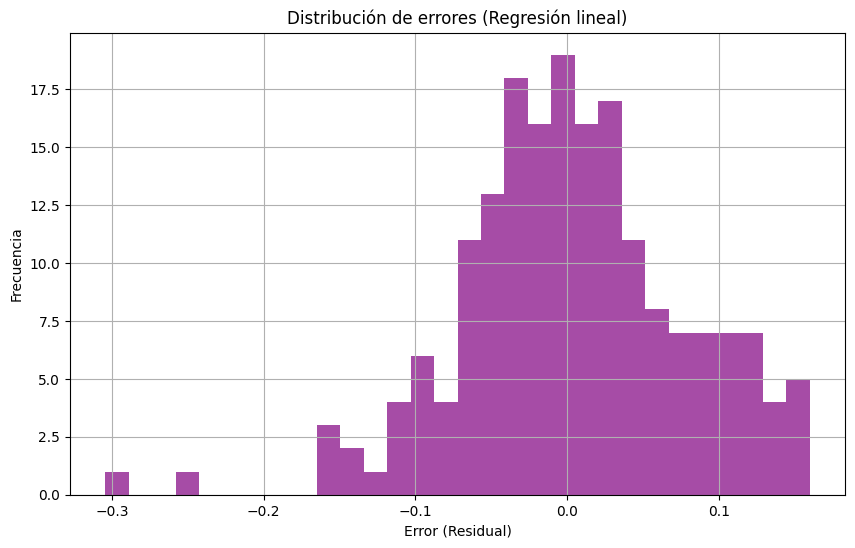

In [155]:
# gráfica de errores
errors_lr = y_test - y_pred_lr
plot_errores("Regresión lineal", errors_lr)

### Decision Tree Regressor

In [156]:
# se definen los hiperparámetros a optimizar en esta función
def objective_dt(trial):
    
    # hiperparametros a optimizar (ej: entre 50 y 200)
    criterion = trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"])
    max_depth = trial.suggest_int("max_depth", 2, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])

    # crear el modelo
    model = DecisionTreeRegressor(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        splitter=splitter,
        random_state=42
    )

    # defino el cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    mse_mean = -scores_mse.mean()
    return mse_mean

In [157]:
# optimizacion
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=50)

[I 2025-06-16 09:37:05,291] A new study created in memory with name: no-name-5c32700a-9154-4ed0-8c92-e783f47282cd
[I 2025-06-16 09:37:05,341] Trial 0 finished with value: 0.028799017578439234 and parameters: {'criterion': 'squared_error', 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'splitter': 'best'}. Best is trial 0 with value: 0.028799017578439234.
[I 2025-06-16 09:37:05,374] Trial 1 finished with value: 0.037694667363890114 and parameters: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'splitter': 'random'}. Best is trial 0 with value: 0.028799017578439234.
[I 2025-06-16 09:37:05,421] Trial 2 finished with value: 0.015433660335209928 and parameters: {'criterion': 'squared_error', 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None, 'splitter': 'random'}. Best is trial 2 with value: 0.015433660335209928.
[I 2025-06-16 09:37:05,460] Tri

In [158]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para Decision Tree:")
print(study_dt.best_params)
print("Mejor MSE:", study_dt.best_value)


Mejores parámetros encontrados para Decision Tree:
{'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None, 'splitter': 'best'}
Mejor MSE: 0.01360013724794092


In [159]:
# entreno el modelo con los mejores parámetros
best_model_dt_reg = DecisionTreeRegressor(**study_dt.best_params, random_state=42)
best_model_dt_reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,7
,min_samples_split,15
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [160]:
# evaluación del modelo
y_pred_dt = best_model_dt_reg.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)

r2_dt = r2_score(y_test, y_pred_dt)

print("\nEvaluación del Modelo de Regresión:")
print(f"Decision Tree Mean Squared Error (MSE): {mse_dt:.4f}")
print(f"Decision Tree R² Score: {r2_dt:.4f}")

# importancia de variables
importances_dt = best_model_dt_reg.feature_importances_


Evaluación del Modelo de Regresión:
Decision Tree Mean Squared Error (MSE): 0.0150
Decision Tree R² Score: 0.7342


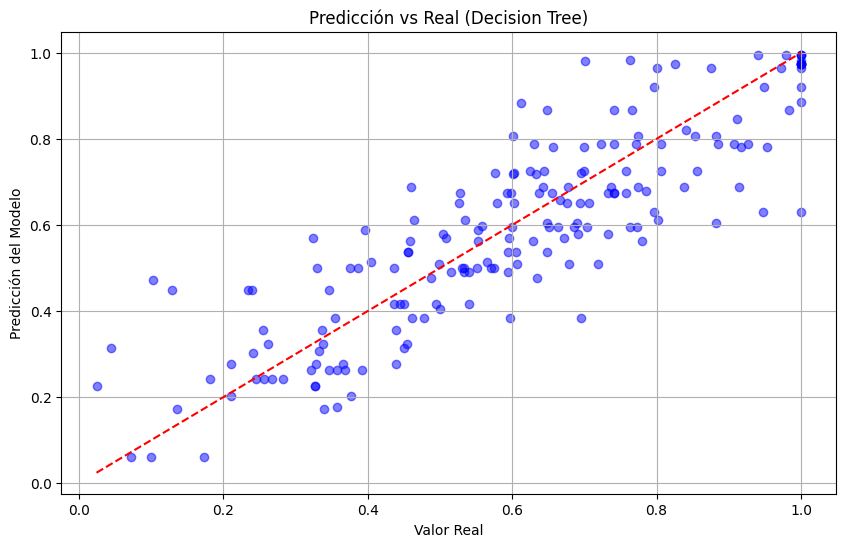

In [161]:
# grafico
plot_prediccion_vs_real("Decision Tree", y_test, y_pred_dt)

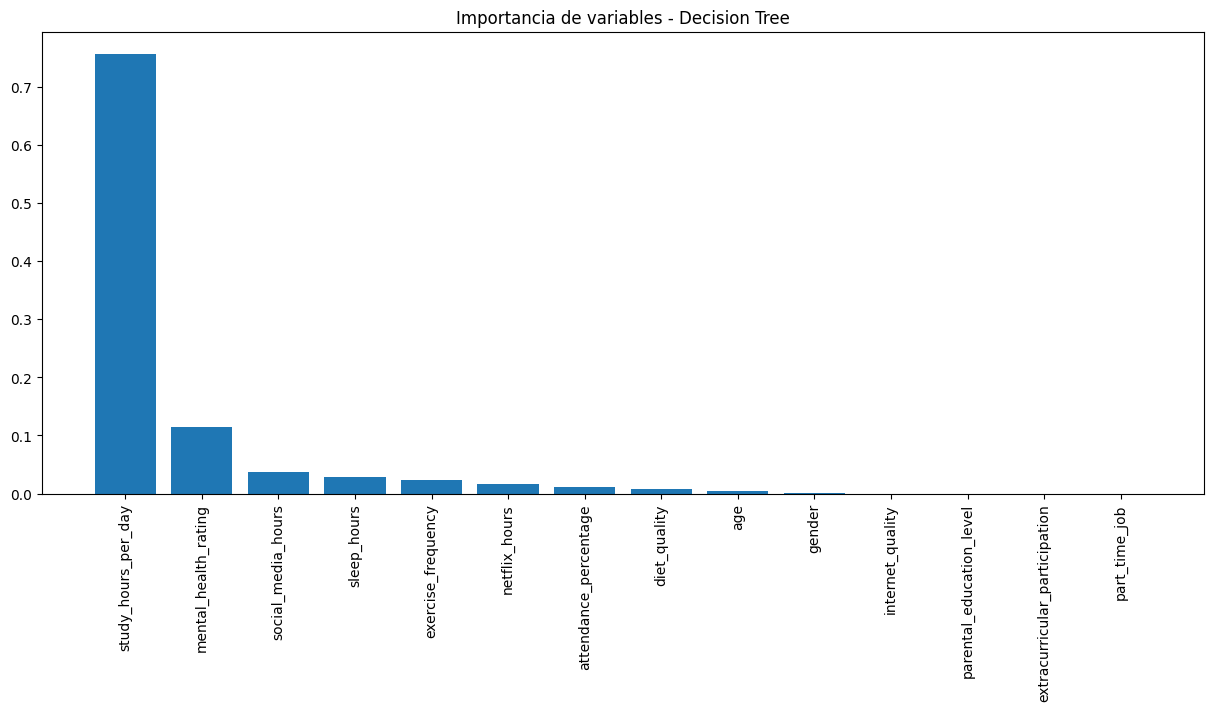

In [162]:
# importancia de variables en el modelo
plot_importance("Decision Tree", importances_dt)

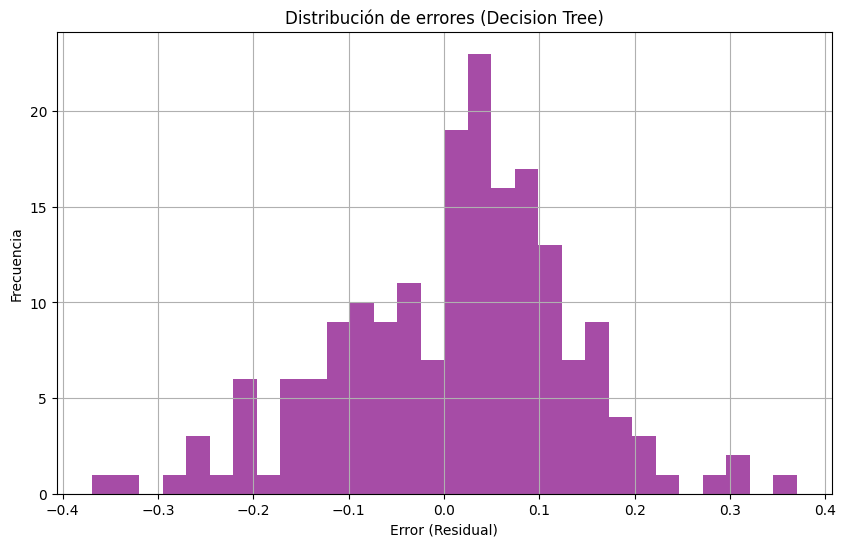

In [163]:
# gráfica de errores
errors_dt = y_test - y_pred_dt
plot_errores("Decision Tree", errors_dt)

### Random Forest Regressor

In [164]:
# se definen los hiperparámetros a optimizar en esta función
def objective_rf(trial):
    # hiperparametros a optimizar (ej: entre 50 y 200)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # crear el modelo
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )
    # defino el cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    mse_mean = -scores_mse.mean()
    return mse_mean

In [165]:
# optimizacion
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)

[I 2025-06-16 09:37:11,553] A new study created in memory with name: no-name-9045f5d1-c3a7-4c78-820f-89f8db1b4b84
[I 2025-06-16 09:37:15,268] Trial 0 finished with value: 0.00831588307647376 and parameters: {'n_estimators': 142, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.00831588307647376.
[I 2025-06-16 09:37:16,708] Trial 1 finished with value: 0.011966413069152481 and parameters: {'n_estimators': 67, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.00831588307647376.
[I 2025-06-16 09:37:19,749] Trial 2 finished with value: 0.017956860312657138 and parameters: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.00831588307647376.
[I 2025-06-16 09:37:25,280] Trial 3 finished with value: 0.015849844695

In [166]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para Random Forest:")
print(study_rf.best_params)
print("Mejor MSE:", study_rf.best_value)


Mejores parámetros encontrados para Random Forest:
{'n_estimators': 116, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Mejor MSE: 0.007466867318741103


In [167]:
# entreno el modelo con los mejores parámetros
best_model_rf_reg = RandomForestRegressor(**study_rf.best_params, random_state=42)
best_model_rf_reg.fit(X_train, y_train)

,n_estimators,116
,criterion,'squared_error'
,max_depth,13
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [168]:
# evaluación del modelo
y_pred_rf = best_model_rf_reg.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

r2_rf = r2_score(y_test, y_pred_rf)

print("\nEvaluación del Modelo de Regresión:")
print(f"Random Forest Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")

# importancia de variables
importances_rf = best_model_rf_reg.feature_importances_


Evaluación del Modelo de Regresión:
Random Forest Mean Squared Error (MSE): 0.0077
Random Forest R² Score: 0.8632


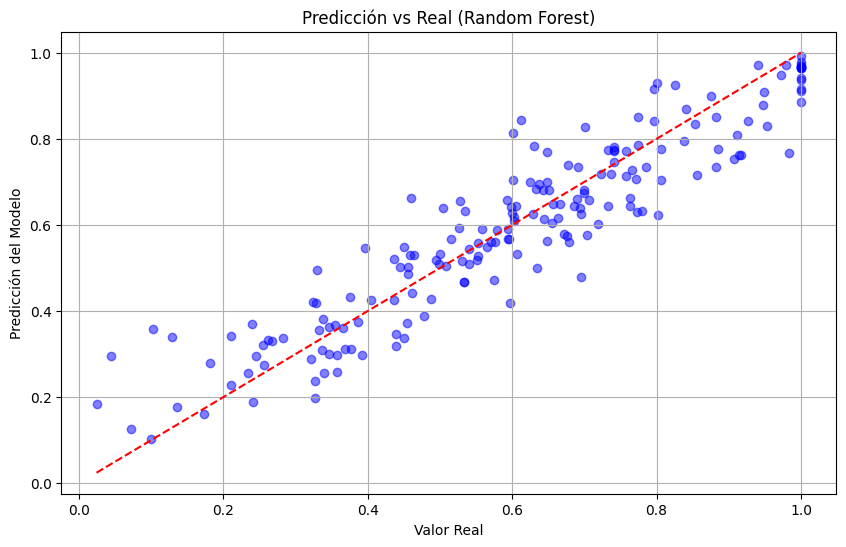

In [169]:
# grafico
plot_prediccion_vs_real("Random Forest", y_test, y_pred_rf) # gráfica del mode


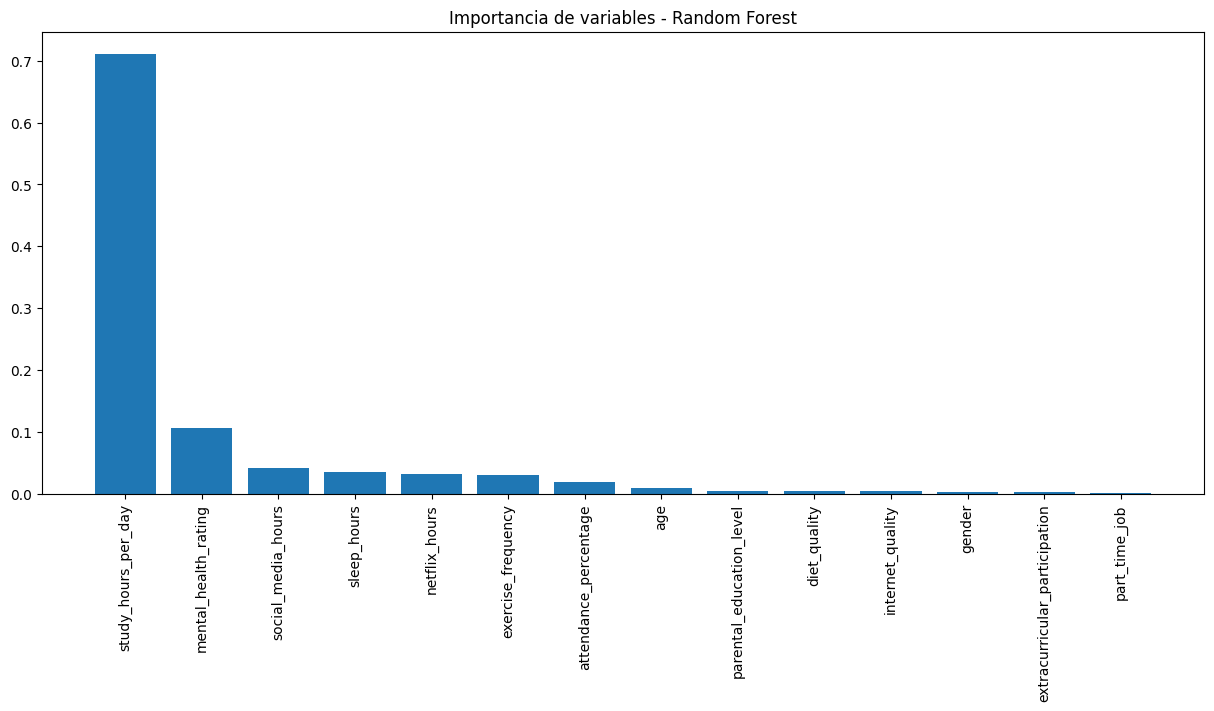

In [170]:
# importancia de variables en el modelo
plot_importance("Random Forest", importances_rf)

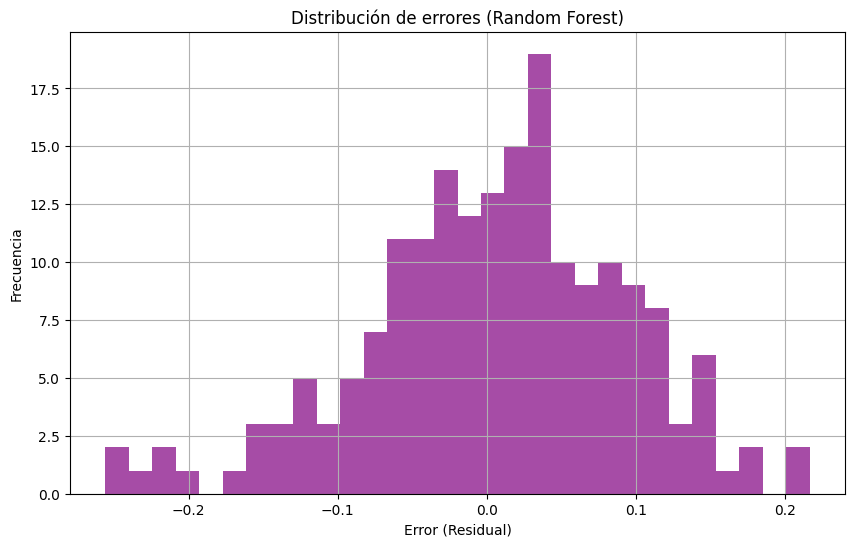

In [171]:
# gráfica de errores
errors_rf = y_test - y_pred_rf
plot_errores("Random Forest", errors_rf)

### Gradient Boosting Regressor

In [172]:
# se definen los hiperparámetros a optimizar en esta función
def objective_gb(trial):
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = GradientBoostingRegressor(**params)

    # defino el cross validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

    mse_mean = -scores_mse.mean()
    return mse_mean

In [173]:
# optimizacion
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=50)

[I 2025-06-16 09:40:29,865] A new study created in memory with name: no-name-1efb090b-1f41-47eb-ae64-1d22631cd435
[I 2025-06-16 09:40:34,469] Trial 0 finished with value: 0.005703457316108715 and parameters: {'n_estimators': 223, 'learning_rate': 0.0435698568554903, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 19, 'subsample': 0.5330269014992669, 'max_features': None}. Best is trial 0 with value: 0.005703457316108715.
[I 2025-06-16 09:40:36,199] Trial 1 finished with value: 0.006891253020324938 and parameters: {'n_estimators': 110, 'learning_rate': 0.06981151071899847, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 8, 'subsample': 0.8174638453723356, 'max_features': 'log2'}. Best is trial 0 with value: 0.005703457316108715.
[I 2025-06-16 09:40:45,069] Trial 2 finished with value: 0.006216850233510167 and parameters: {'n_estimators': 290, 'learning_rate': 0.06351192154915705, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 18, 'subsample': 0.77

In [174]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para Gradient Boosting:")
print(study_gb.best_params)
print("Mejor MSE:", study_gb.best_value)



Mejores parámetros encontrados para Gradient Boosting:
{'n_estimators': 204, 'learning_rate': 0.030735496495805547, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 15, 'subsample': 0.5193125619997736, 'max_features': None}
Mejor MSE: 0.005522785738577562


In [175]:
# entreno el modelo con los mejores parámetros
best_model_gb_reg = GradientBoostingRegressor(**study_gb.best_params, random_state=42)
best_model_gb_reg.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.030735496495805547
,n_estimators,204
,subsample,0.5193125619997736
,criterion,'friedman_mse'
,min_samples_split,3
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [176]:
# evaluación del modelo
y_pred_gb = best_model_gb_reg.predict(X_test)

mse_gb = mean_squared_error(y_test, y_pred_gb)

r2_gb = r2_score(y_test, y_pred_gb)

print("\nEvaluación del Modelo de Regresión:")
print(f"Gradient Boosting Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"Gradient Boosting R² Score: {r2_gb:.4f}")

# importancia de variables
importances_gb= best_model_gb_reg.feature_importances_


Evaluación del Modelo de Regresión:
Gradient Boosting Mean Squared Error (MSE): 0.0059
Gradient Boosting R² Score: 0.8957


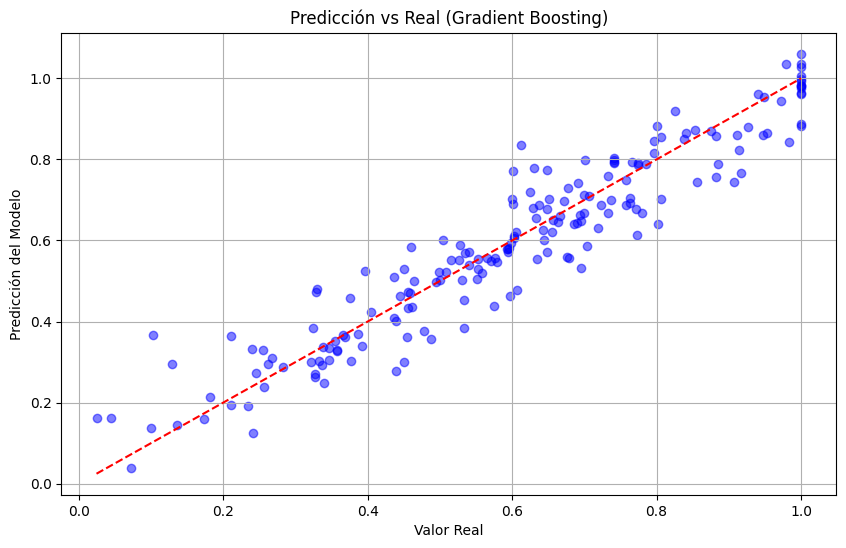

In [177]:
plot_prediccion_vs_real("Gradient Boosting", y_test, y_pred_gb)

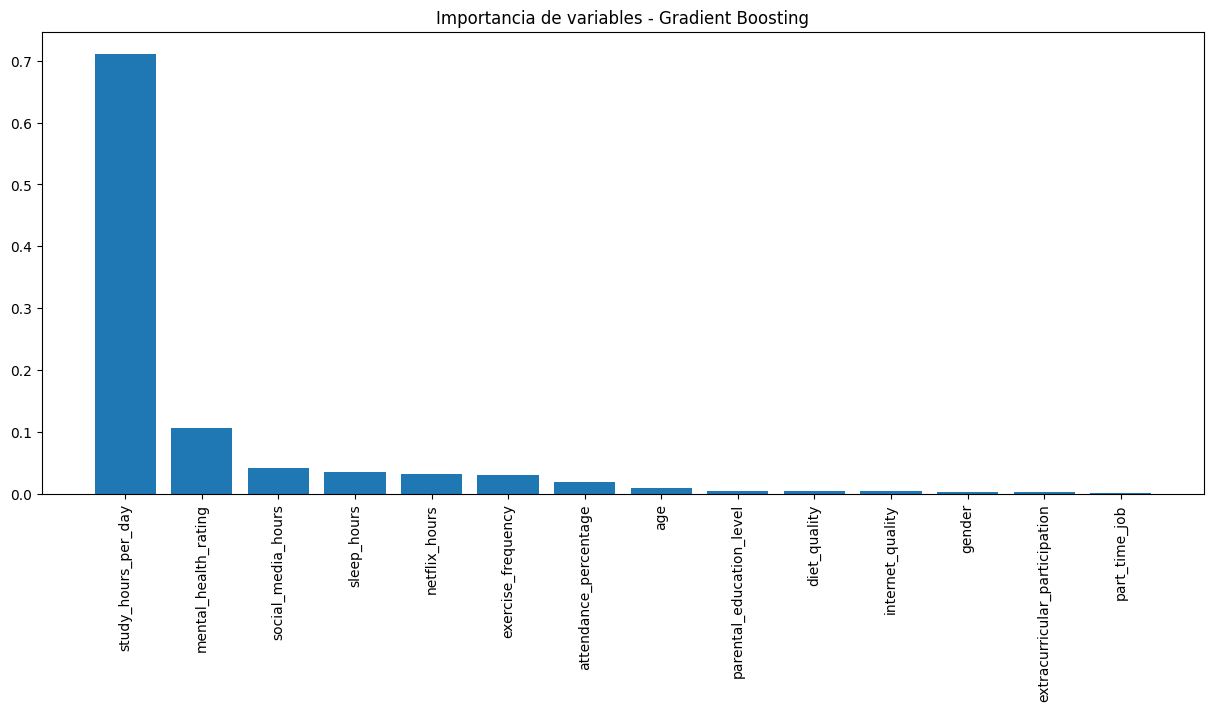

In [178]:
plot_importance("Gradient Boosting", importances_rf)

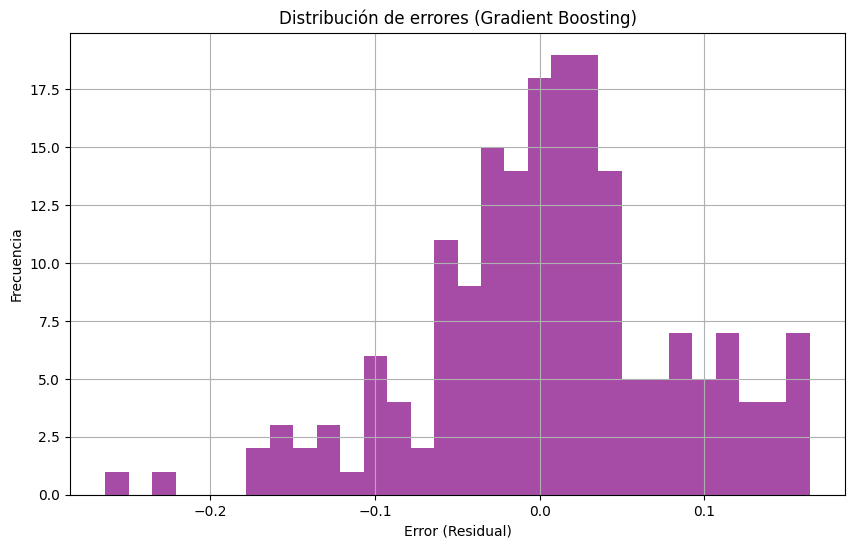

In [179]:
errors_gb = y_test - y_pred_gb
plot_errores("Gradient Boosting", errors_gb)

### MLP

In [180]:
def objective_mlp(trial):
    hidden_layer_sizes_str = trial.suggest_categorical(
        "hidden_layer_sizes_str",
        ["50", "100", "50-50", "100-50", "100-100"]
    )
    hidden_layer_sizes = tuple(int(i) for i in hidden_layer_sizes_str.split('-'))

    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd", "lbfgs"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 300, 1000)
    early_stopping = trial.suggest_categorical("early_stopping", [True, False])

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        early_stopping=early_stopping,
        random_state=42
    )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return -scores.mean()

In [ ]:
# optimizacion
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=50)

In [182]:
# mejores parametros encontrados y sus resultados
print("\nMejores parámetros encontrados para MLP:")
print(study_mlp.best_params)
print("Mejor MSE:", study_mlp.best_value)


Mejores parámetros encontrados para MLP:
{'hidden_layer_sizes_str': '100-100', 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.006339975109524575, 'learning_rate_init': 0.018719897258507527, 'max_iter': 761, 'early_stopping': True}
Mejor MSE: 0.005077321611641537


In [183]:
# entreno el modelo con los mejores parámetros

hidden_layer_sizes = tuple(int(i) for i in study_mlp.best_params["hidden_layer_sizes_str"].split('-'))

best_model_mlp_reg = MLPRegressor(
    hidden_layer_sizes=hidden_layer_sizes,
    activation=study_mlp.best_params["activation"],
    solver=study_mlp.best_params["solver"],
    alpha=study_mlp.best_params["alpha"],
    learning_rate_init=study_mlp.best_params["learning_rate_init"],
    max_iter=study_mlp.best_params["max_iter"],
    early_stopping=study_mlp.best_params["early_stopping"],
    random_state=42
)
best_model_mlp_reg.fit(X_train, y_train)

,loss,'squared_error'
,hidden_layer_sizes,"(100, ...)"
,activation,'logistic'
,solver,'lbfgs'
,alpha,0.006339975109524575
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.018719897258507527
,power_t,0.5
,max_iter,761
,shuffle,True


In [184]:
# evaluación del modelo
y_pred_mlp = best_model_mlp_reg.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)

r2_mlp = r2_score(y_test, y_pred_mlp)

print("\nEvaluación del Modelo de Regresión:")
print(f"Random Forest Mean Squared Error (MSE): {mse_mlp:.4f}")
print(f"Random Forest R² Score: {r2_mlp:.4f}")


Evaluación del Modelo de Regresión:
Random Forest Mean Squared Error (MSE): 0.0053
Random Forest R² Score: 0.9061


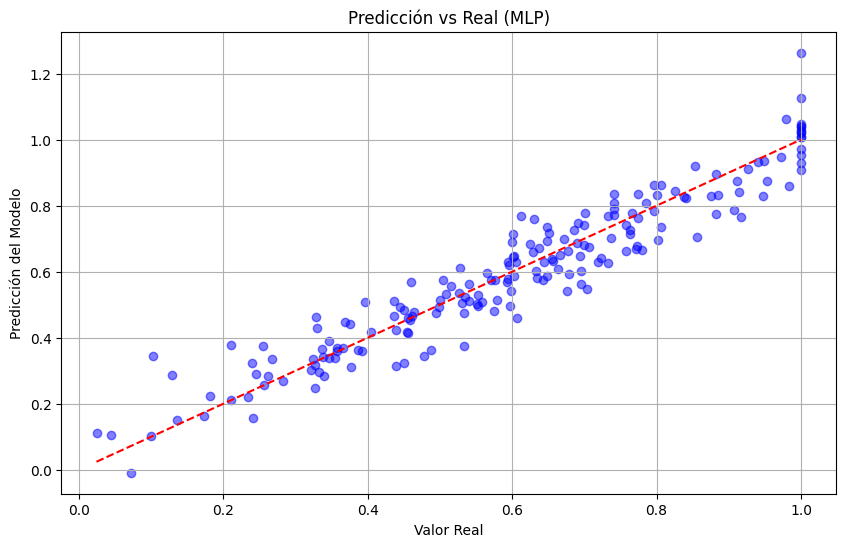

In [185]:
plot_prediccion_vs_real("MLP", y_test, y_pred_mlp)

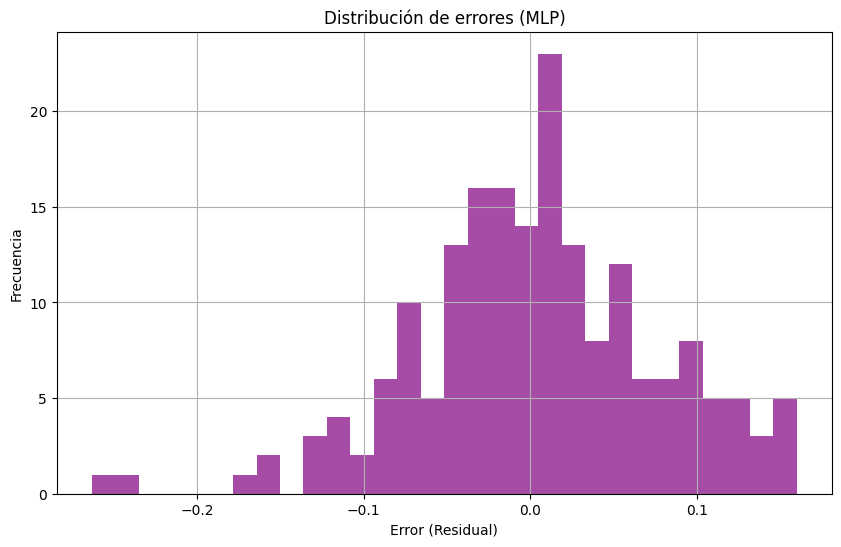

In [186]:
errors_mlp = y_test - y_pred_mlp
plot_errores("MLP", errors_mlp)

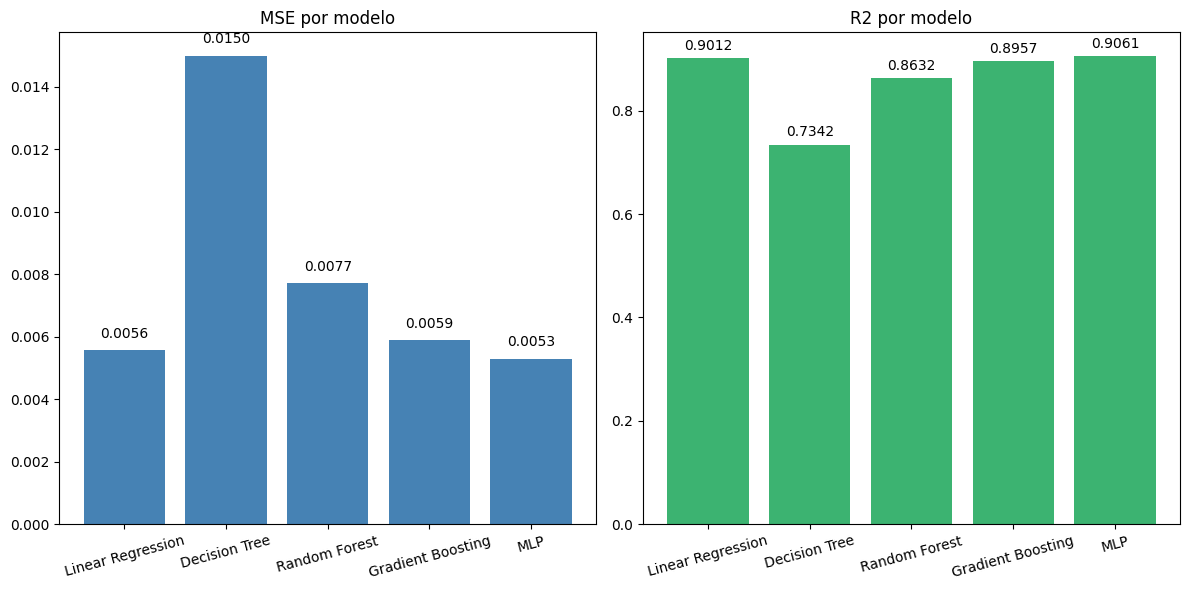

In [187]:
models = [ 'Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting','MLP']
mse = [
      mse_lr,
      mse_dt,
      mse_rf,
      mse_gb,
      mse_mlp]

r2 = [
      r2_lr,
      r2_dt,
      r2_rf,
      r2_gb,
      r2_mlp]

plt.figure(figsize=(12, 6))

# Gráfico MSE
plt.subplot(1, 2, 1)
plt.bar(models, mse, color='steelblue')
for i, v in enumerate(mse):
    plt.text(i, v + max(mse)*0.02, f"{v:.4f}", ha='center', va='bottom')  # ajusta la posición
plt.title('MSE por modelo')
plt.xticks(rotation=15)

# Gráfico R2
plt.subplot(1, 2, 2)
plt.bar(models, r2, color='mediumseagreen')
for i, v in enumerate(r2):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
plt.title('R2 por modelo')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

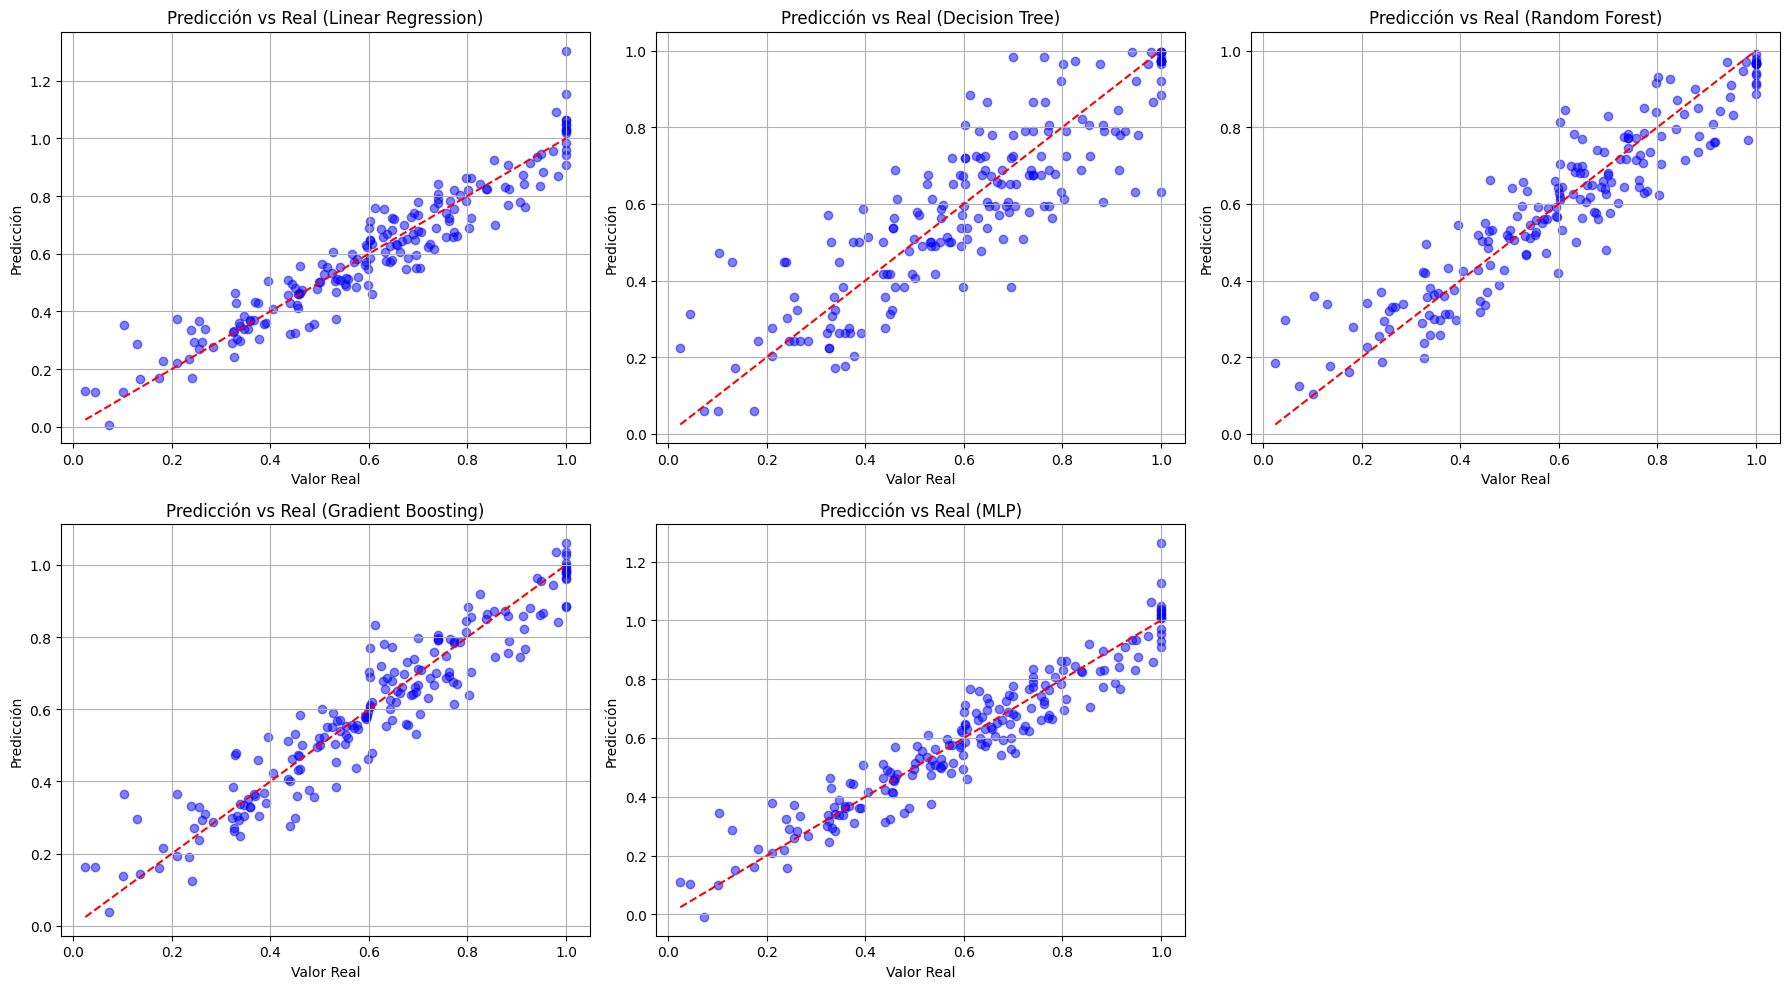

In [188]:

predicciones = {
    'Linear Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb,
    'MLP': y_pred_mlp
}


plt.figure(figsize=(18, 10))
for i, (nombre_modelo, y_pred) in enumerate(predicciones.items(), start=1):
    plt.subplot(2, 3, i)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f'Predicción vs Real ({nombre_modelo})')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.grid(True)


plt.tight_layout()
plt.show()

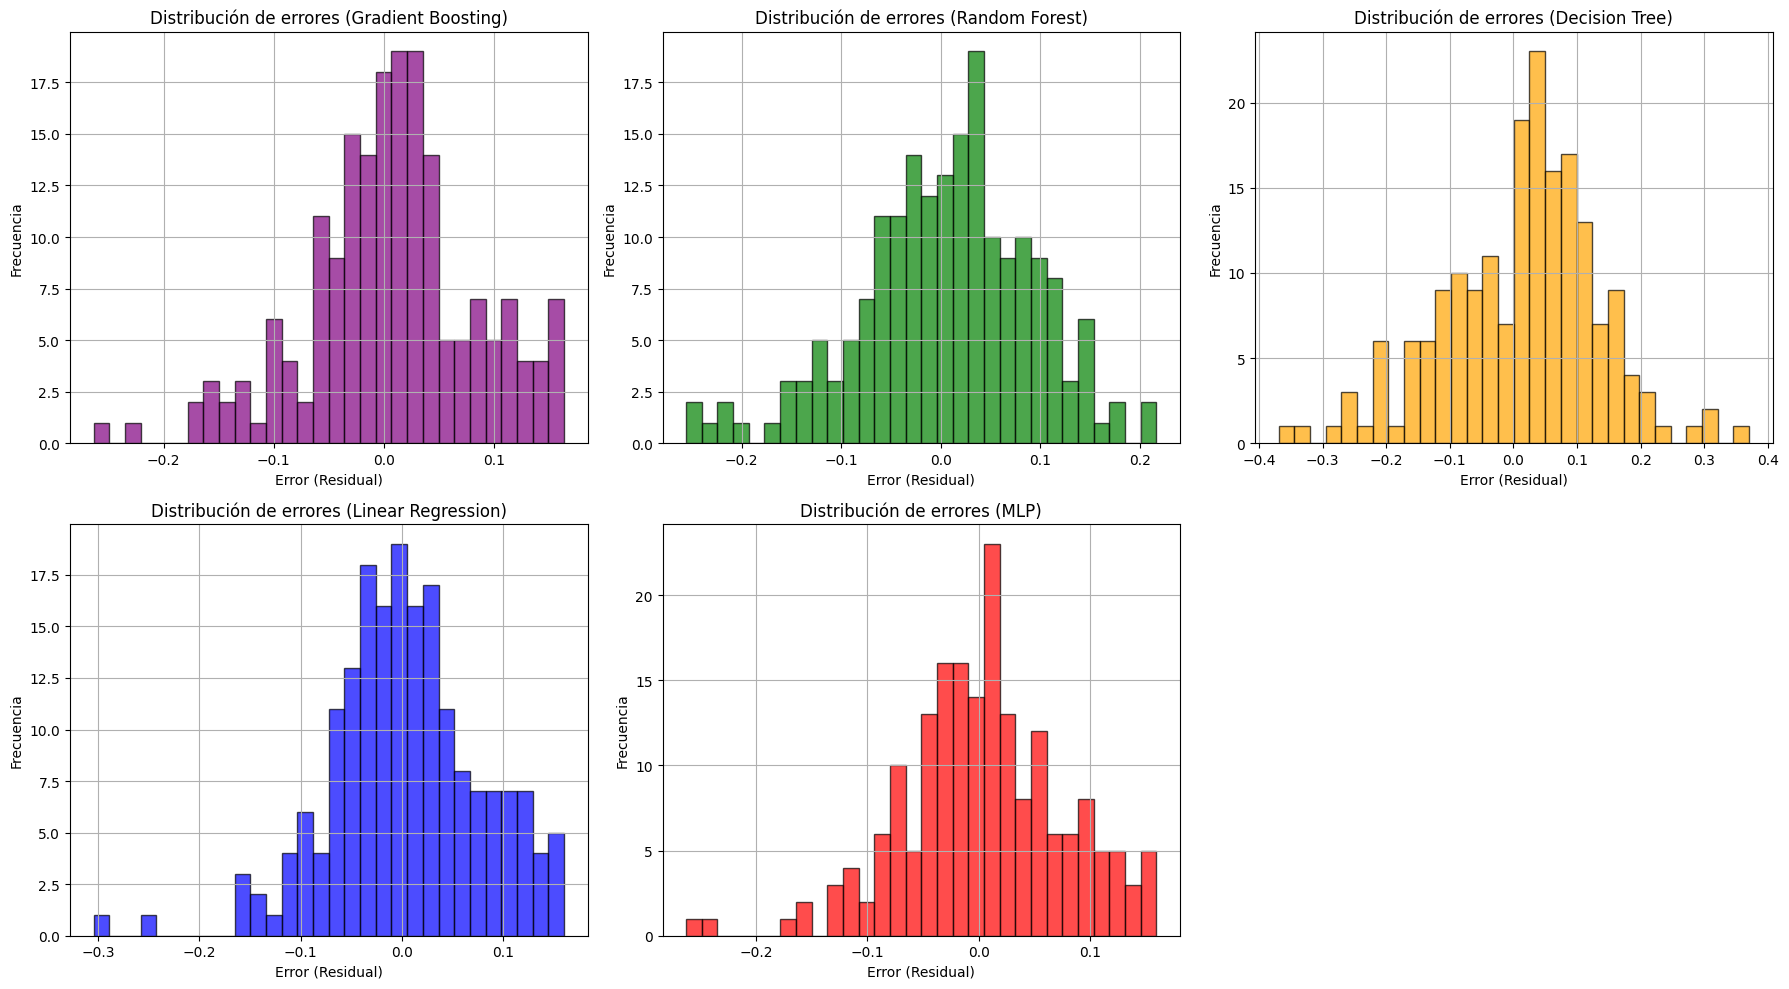

In [189]:
# Crear una figura grande para comparar todas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 filas, 3 columnas

# Graficar cada uno en su respectivo 'axes'
modelos = ['Gradient Boosting', 'Random Forest', 'Decision Tree', 'Linear Regression', 'MLP']
errores = [errors_gb, errors_rf, errors_dt, errors_lr, errors_mlp]
colores = ['purple', 'green', 'orange', 'blue', 'red']

for idx, ax in enumerate(axes.flat[:5]):  # Solo usas los primeros 5 espacios
    ax.hist(errores[idx], bins=30, color=colores[idx], edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribución de errores ({modelos[idx]})')
    ax.set_xlabel('Error (Residual)')
    ax.set_ylabel('Frecuencia')
    ax.grid(True)

# Eliminar el subplot vacío si no usas los 6 espacios
fig.delaxes(axes[1,2])  # Borra el último si solo tienes 5 modelos

plt.tight_layout()
plt.show()